In [ ]:
from random import seed
from time import sleep
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras import layers
from keras.constraints import maxnorm
from keras.utils import np_utils
from imutils import paths
import matplotlib.pyplot as plt

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
def plotGraphs(history, epochs)->None:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
def conv_2d_pooling_layers(filters, number_colour_layers: int):
    return [
        tf.keras.layers.Conv2D(
            filters,
            number_colour_layers,
            padding='same',
            activation='relu'
        ),
        tf.keras.layers.MaxPooling2D()
    ]

In [ ]:
color_mode = 'RGB'
number_colour_layers = 3
image_size = (100, 100)
image_shape = image_size + (number_colour_layers,)

#paths das imagens
training_data_path = './Cartas/data/train'
test_data_path = './Cartas/data/test'
val_data_path = './Cartas/data/validation'

#armazenar os ds
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_path,
    seed=42,
    image_size=image_size,
    batch_size=32
)
train_ds = tf.keras.utils.image_dataset_from_directory(
    training_data_path,
    seed=42,
    image_size=image_size,
    batch_size=32
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_data_path,
    seed=42,
    image_size=image_size,
    batch_size=32
)

Found 1920 files belonging to 51 classes.
Found 11894 files belonging to 51 classes.
Found 2035 files belonging to 51 classes.


['10_COPAS', '10_ESPADAS', '10_OURO', '10_PAUS', '2_COPAS', '2_ESPADAS', '2_OURO', '2_PAUS', '3_COPAS', '3_ESPADAS', '3_OURO', '3_PAUS', '4_COPAS', '4_ESPADAS', '4_OURO', '4_PAUS', '5_COPAS', '5_ESPADAS', '5_OURO', '5_PAUS', '6_COPAS', '6_ESPADAS', '6_OURO', '6_PAUS', '7_COPAS', '7_ESPADAS', '7_OURO', '7_PAUS', '8_COPAS', '8_ESPDAS', '8_OURO', '8_PAUS', '9_COPAS', '9_ESPADAS', '9_OURO', '9_PAUS', 'A_COPAS', 'A_OURO', 'A_PAUS', 'J_COPAS', 'J_ESPADAS', 'J_OURO', 'J_PAUS', 'K_COPAS', 'K_ESPADAS', 'K_OURO', 'K_PAUS', 'Q_COPAS', 'Q_ESPADAS', 'Q_OURO', 'Q_PAUS']


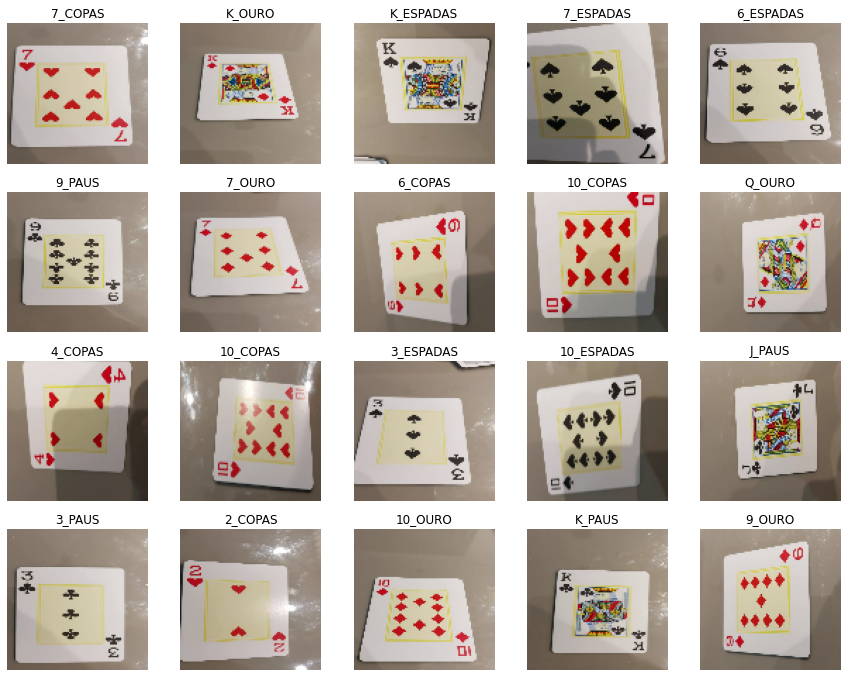

In [ ]:
class_names = train_ds.class_names
print(class_names) 
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(20):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [ ]:
#Config for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
num_classes = len(class_names)

In [ ]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=image_shape),
    tf.keras.Sequential(
    [
      layers.RandomFlip("vertical",
                        input_shape=image_shape),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.1),
    ])
]

core_layers = \
    conv_2d_pooling_layers(16, number_colour_layers) + \
    conv_2d_pooling_layers(32, number_colour_layers) + \
    conv_2d_pooling_layers(64, number_colour_layers)

dense_layers = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
]

#juntar os layers com o modelo sequencial
model = tf.keras.Sequential(
    preprocessing_layers +
    core_layers +
    dense_layers
)

#loss usando categorial do keras
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
model.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)

#Callback para evitar overfitting
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)

In [ ]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_19 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 sequential_19 (Sequential)  (None, 100, 100, 3)       0         
                                                                 
 conv2d_57 (Conv2D)          (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 50, 50, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                

In [ ]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 20,
    callbacks = [callback]
)

Epoch 1/20
372/372 [==============================] - 44s 114ms/step - loss: 2.3084 - accuracy: 0.3308 - val_loss: 1.4939 - val_accuracy: 0.5725
Epoch 2/20
372/372 [==============================] - 44s 116ms/step - loss: 0.8515 - accuracy: 0.7180 - val_loss: 0.9495 - val_accuracy: 0.7106
Epoch 3/20
372/372 [==============================] - 48s 128ms/step - loss: 0.4922 - accuracy: 0.8331 - val_loss: 0.4646 - val_accuracy: 0.8462
Epoch 4/20
372/372 [==============================] - 44s 117ms/step - loss: 0.3234 - accuracy: 0.8926 - val_loss: 0.4106 - val_accuracy: 0.8801
Epoch 5/20
372/372 [==============================] - 44s 116ms/step - loss: 0.2262 - accuracy: 0.9232 - val_loss: 0.2347 - val_accuracy: 0.9209
Epoch 6/20
372/372 [==============================] - 44s 116ms/step - loss: 0.1796 - accuracy: 0.9401 - val_loss: 0.1545 - val_accuracy: 0.9445
Epoch 7/20
372/372 [==============================] - 44s 117ms/step - loss: 0.1313 - accuracy: 0.9575 - val_loss: 0.2183 - val_ac

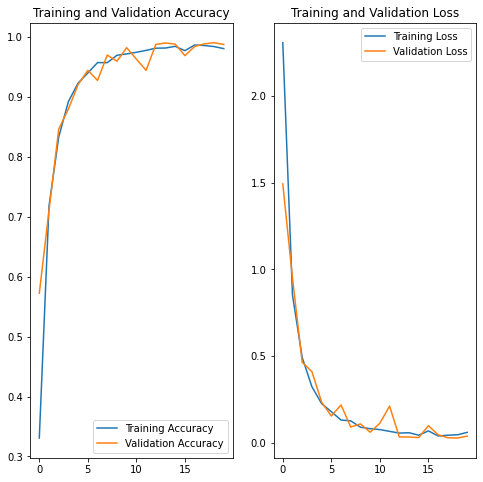

In [ ]:
plotGraphs(history=history, epochs=10)

In [ ]:
score = model.evaluate(test_ds)

60/60 [==============================] - 6s 95ms/step - loss: 0.0392 - accuracy: 0.9875


In [ ]:
CardPath = './1.jpg'
Card = tf.keras.utils.load_img(
    CardPath, target_size=image_size
)
Card_array = tf.keras.utils.img_to_array(Card)
Card_array = tf.expand_dims(Card_array, 0) # Create a batch

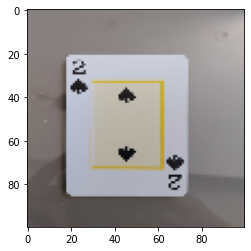

In [ ]:
plt.imshow(Card)
plt.show()


In [ ]:
predictions = model.predict(Card_array)
score = tf.nn.softmax(predictions[0])

In [ ]:
np.argmax(score)

7

In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 2_PAUS with a 99.09 percent confidence.
